In [63]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [64]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = pd.read_csv(url, sep=';')


In [65]:
# Separate features and target variable
X = data.drop(columns=['quality']).values  # Explanatory variables
y = data['quality'].values  # Response variable

# --- (a) Fixed Acidity normalization (first column)
fixed_acidity = X[:, 0].reshape(-1, 1)
fixed_acidity = (fixed_acidity - 7) / 7   # centered at 7

# --- (b) Residual Sugar normalization (column 3)
residual_sugar = X[:, 3].reshape(-1, 1)
scaler = StandardScaler()
residual_sugar = scaler.fit_transform(residual_sugar)

# --- (c) Normalize the remaining columns manually (columns 1-2 and 4-10)
columns_to_normalize = np.delete(np.arange(X.shape[1]), [0, 3])  # all except 0 and 3
X_other = X[:, columns_to_normalize]
X_mean = X_other.mean(axis=0)
X_std = X_other.std(axis=0)
X_other = (X_other - X_mean) / X_std

# --- (d) Reconstruct X in the original order
# Columns: [fixed acidity, X[:,1], X[:,2], residual sugar, X[:,4], ..., X[:,10]]
X = np.hstack([
    fixed_acidity,
    X_other[:, :2],         # columns 1 and 2
    residual_sugar,
    X_other[:, 2:]          # columns 4 to 10
])

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Reshape for PyTorch


In [66]:
class WineQualityModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(WineQualityModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 10)  # Hidden layer with 10 neurons
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(10, output_size)  # Output layer

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# Initialize model
input_size = X.shape[1]  # Number of features
output_size = 1  # Predicting a single value (quality)
model = WineQualityModel(input_size, output_size)


In [67]:
criterion = nn.MSELoss()  # Loss function
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Optimizer using gradient descent


In [68]:
epochs = 600
losses = []  # To store loss per epoch

for epoch in range(epochs):
    # Forward pass: Compute predicted values
    y_pred = model(X)

    # Compute loss
    loss = criterion(y_pred, y)
    losses.append(loss.item())  # Store loss for plotting

    # Backward pass: Compute gradients
    optimizer.zero_grad()
    loss.backward()

    # Update weights using gradient descent
    optimizer.step()

    # Print progress
    if (epoch+1) % 60 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 60/600, Loss: 1.2047
Epoch 120/600, Loss: 0.7660
Epoch 180/600, Loss: 0.6595
Epoch 240/600, Loss: 0.6117
Epoch 300/600, Loss: 0.5890
Epoch 360/600, Loss: 0.5756
Epoch 420/600, Loss: 0.5666
Epoch 480/600, Loss: 0.5599
Epoch 540/600, Loss: 0.5541
Epoch 600/600, Loss: 0.5491


In [69]:
with torch.no_grad():  # No need to compute gradients for inference
    predictions = model(X)
print(predictions)


tensor([[6.1446],
        [5.2137],
        [5.6707],
        ...,
        [5.2976],
        [6.8061],
        [6.4371]])


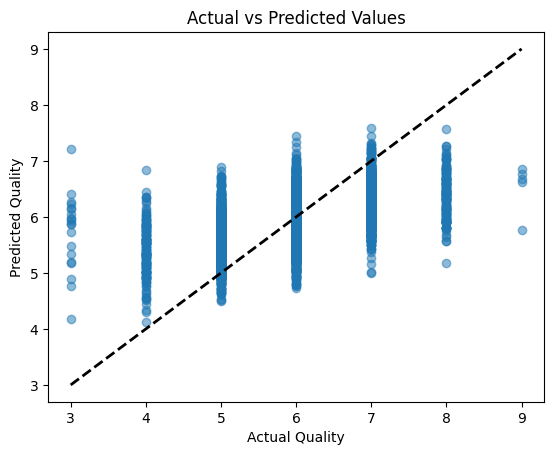

In [70]:
plt.scatter(y.numpy(), predictions.numpy(), alpha=0.5)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Actual vs Predicted Values")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()


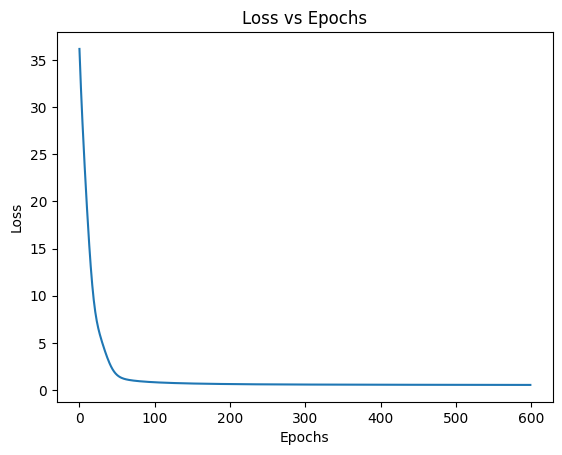

In [71]:
plt.plot(range(epochs), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()
